In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import mobilenet_v2
from sklearn.model_selection import train_test_split

dataset_dir = 'dataset'
classes = os.listdir(dataset_dir)
num_classes = len(classes)

In [2]:
# Load the model if exists
model = None
if os.path.exists('model.keras'):
    model = tf.keras.models.load_model('model.keras')
    print("Model loaded successfully")

In [12]:
def cnn_model(input_shape):
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
    ])

    return model

def retrain_model(model, input_shape, classes):
    if model is None:
        model = cnn_model(input_shape)
    else:
        model.pop()

    model.add(layers.Dense(len(classes), activation='sigmoid'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_data, train_labels, epochs):
    model.fit(train_data, train_labels, epochs=epochs)
    return model

def load_dataset(dataset_dir, input_shape):
    data = []
    labels = []
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=input_shape)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            data.append(img_array)
            labels.append(i)
    return np.array(data), np.array(labels)

In [4]:
# Load dataset
data, labels = load_dataset(dataset_dir, (256, 256))
input_shape = data.shape[1:]
data = data / 255.0
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

In [13]:
# Retrain model
model = retrain_model(model, input_shape, classes)

model = train_model(model, train_data, train_labels, 10)


Epoch 1/10


9/9 [==============================] - 166s 17s/step - loss: 3.6781 - accuracy: 0.1289
Epoch 2/10
1/9 [==>...........................] - ETA: 2:13 - loss: 2.4994 - accuracy: 0.1250

: 

In [6]:
# Save model
model.save('model.keras')
print("Model saved successfully")

d:\anaconda3\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully


3/3 [==============================] - 1s 319ms/step - loss: 2.4907 - accuracy: 0.4722
Test accuracy:  0.4722222089767456
3/3 [==============================] - 1s 140ms/step


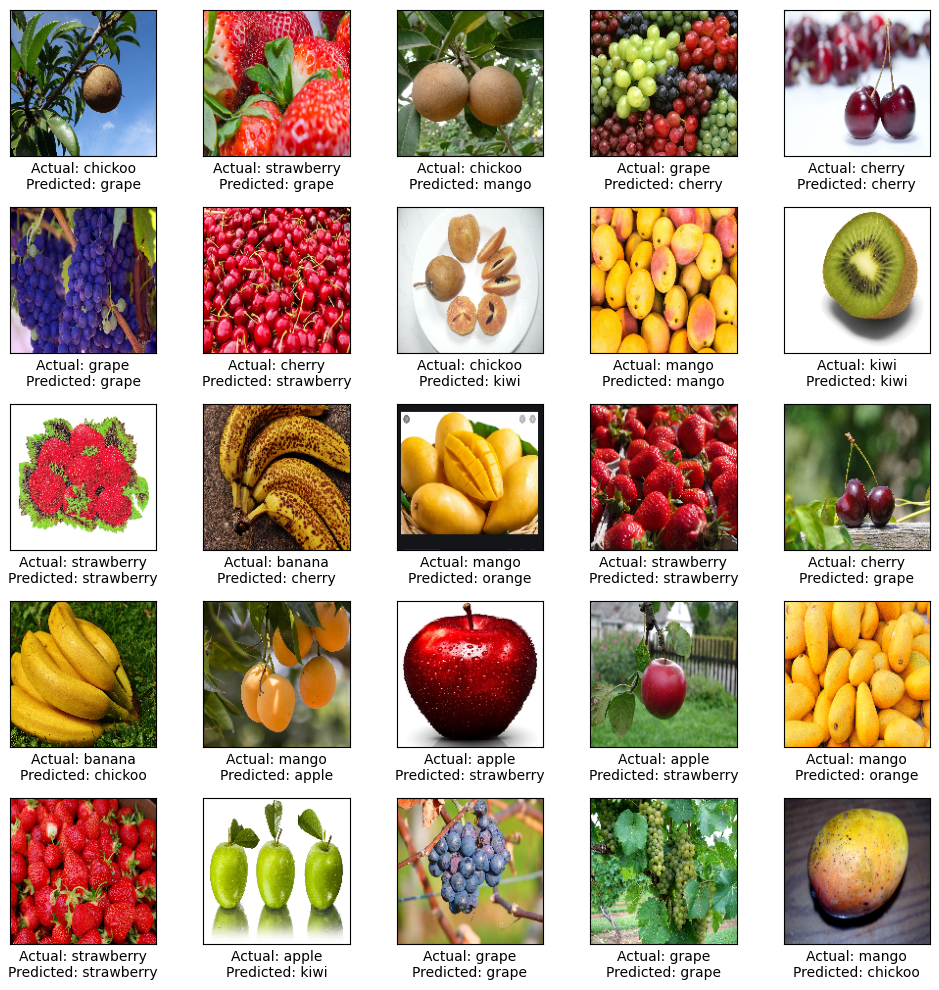

In [18]:
# Test model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print("Test accuracy: ", test_acc)

# Predict
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [classes[label] for label in predicted_labels]
test_predictions = [classes[label] for label in test_labels]

# Plot
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.imshow(test_data[i], cmap=plt.cm.binary)
    plt.xlabel(f"Actual: {test_predictions[i]}\nPredicted: {predicted_labels[i]}")
plt.show()